# KNN vs OLS regression model comparison

Now that we have reviewed and implemented two different regression models, let's see how they compare.  We will use a [US car MPG dataset](https://archive.ics.uci.edu/ml/datasets/Auto+MPG) from the UCI Machine Learning Repository to implement a few instances of KNN and OLS models.  Following this, we will discuss the merits and assess the quality of each.

Our target variable is `mpg`.

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

%matplotlib inline

In [15]:
mpg = pd.read_csv('auto-mpg.data.txt', sep='\s+', na_values='?')

In [47]:
mpg = mpg.dropna()
mpg.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_yr,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


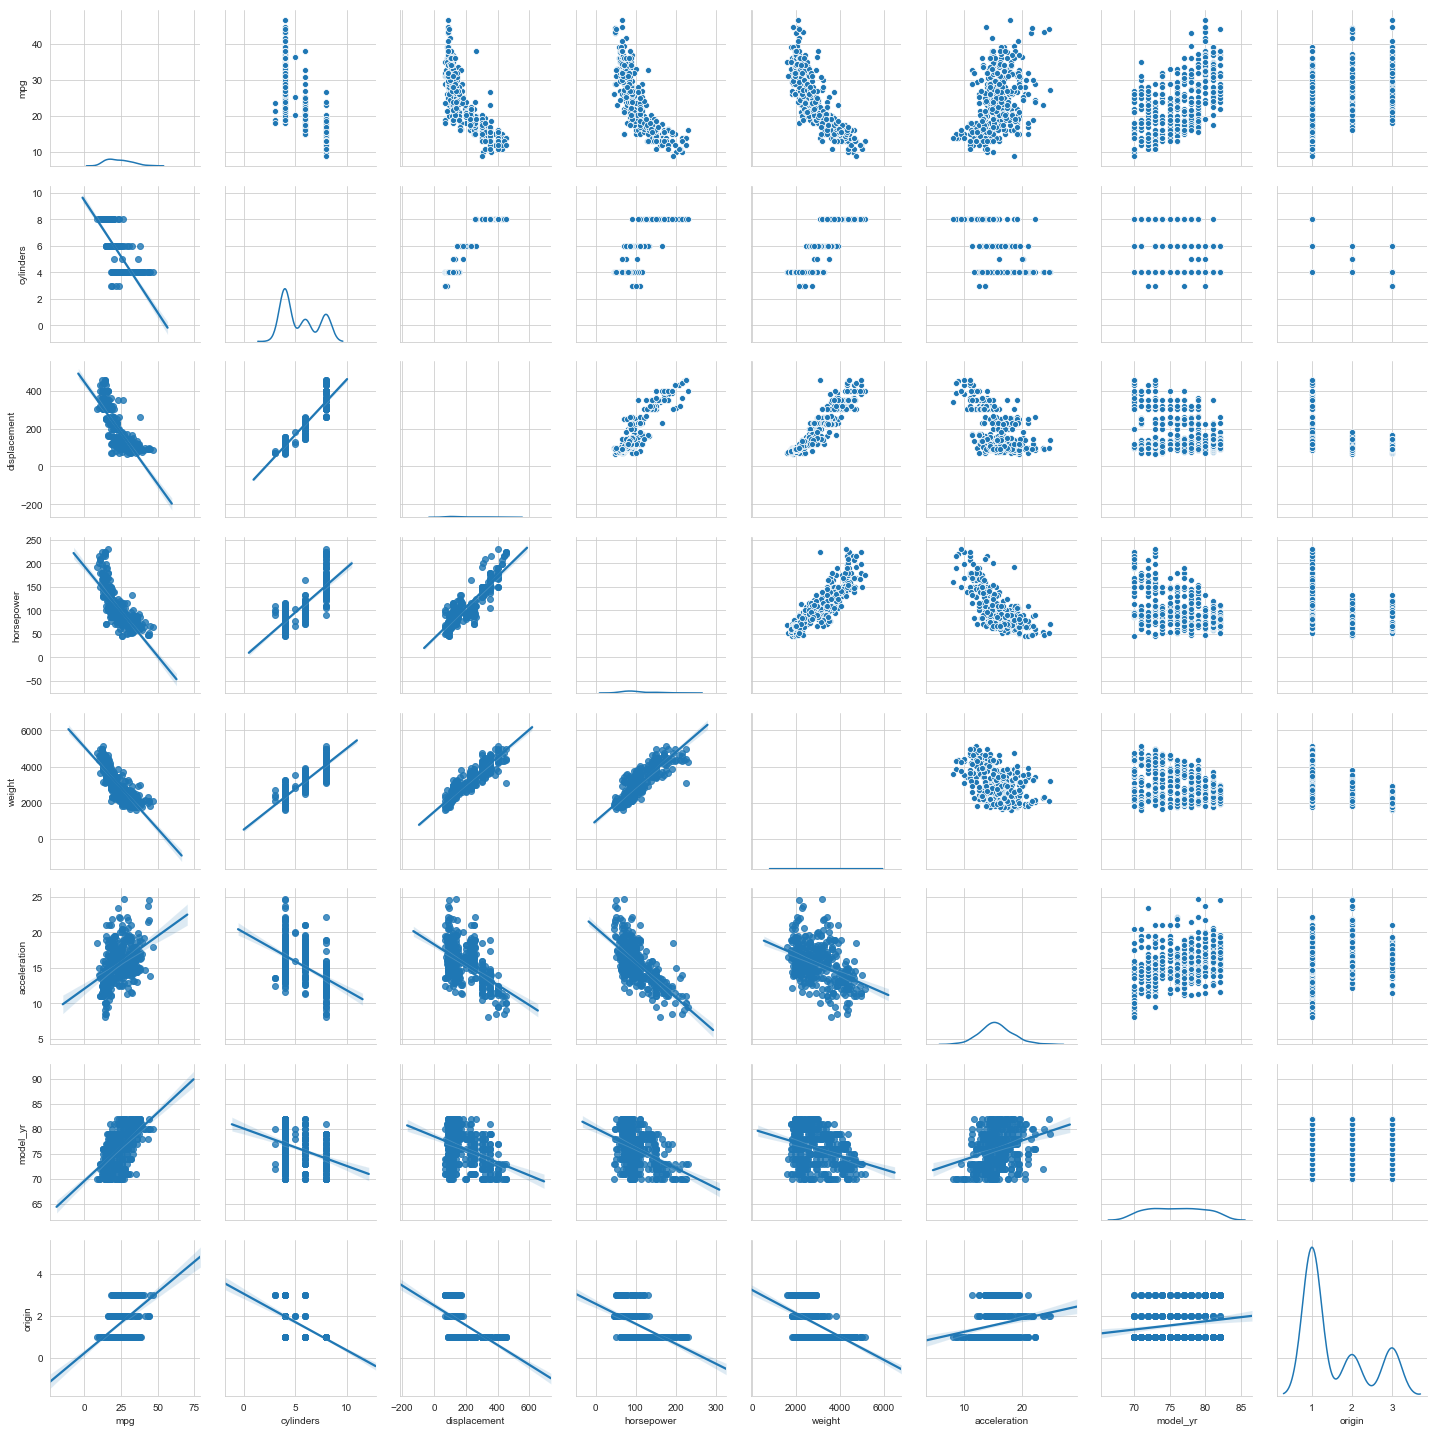

In [48]:
sns.set_style('whitegrid')

g = sns.PairGrid(data=mpg)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.map_lower(sns.regplot)
plt.show()

The best correlated variables to `mpg` are `displacement`, `horsepower`, and `weight`.  These are pretty strongly co-linear so it will be best to run PCA on these variables to have a single feature which accounts for the variance of the three variables combined.  `model_yr` is moderately correlated with `mpg` - and with an opposite correlation than the other 3 variables.  Perhaps it might these models might benefit from the inclusion of `model_yr`.

## PCA

Prior to running PCA, let's do some data transformation on the input variables `displacement`, `horsepower`, and `weight`.  Each of them exhibits a logrithmic trend.  This trend will persist in the PCA if we don't make them linear functions before running PCA.

In [75]:
mpg['disp_log'] = mpg['displacement'].apply(lambda x: np.log10(x))
mpg['hp_log'] = mpg['horsepower'].apply(lambda x: np.log10(x))
mpg['weight_log'] = mpg['weight'].apply(lambda x: np.log10(x))

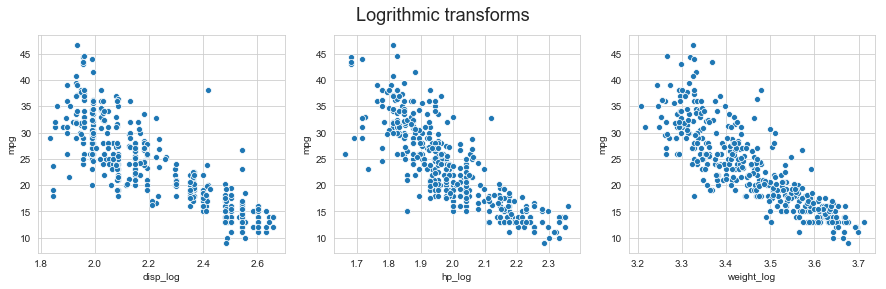

In [85]:
plt.figure(figsize=(15,4))
plt.suptitle('Logrithmic transforms', size=18)

plt.subplot(1,3,1)
sns.scatterplot(data=mpg, x='disp_log', y='mpg')

plt.subplot(1,3,2)
sns.scatterplot(data=mpg, x='hp_log', y='mpg')

plt.subplot(1,3,3)
sns.scatterplot(data=mpg, x='weight_log', y='mpg')
plt.show()

This tranform doesn't completely eliminate the non-linear component of these trends, but they are certainly more linear than they were previously.  Let's plug these into PCA and evaluate how much variance a single feature can characterize.

In [280]:
pca_data = pd.DataFrame({
    'displacement': mpg['disp_log'],
    'horsepower': mpg['hp_log'],
    'weight': mpg['weight_log']
}).dropna()

pca = PCA(n_components=1)
pca.fit(pca_data)
print('Explained variance ratio: ', pca.explained_variance_ratio_)

Explained variance ratio:  [0.94231746]


A single feature from this PCA explains 94% of the variance present in all three of the input variables.  That seems pretty good.  We'll use this feature in our regression modeling.

In [82]:
mpg['pca_feature'] = pca.transform(pca_data)

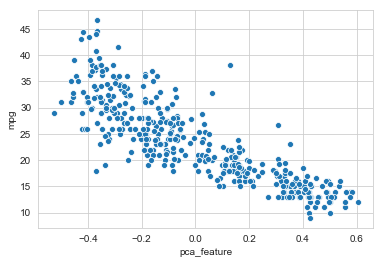

In [83]:
sns.scatterplot(data=mpg, x='pca_feature', y='mpg')
plt.show()

## OLS Regression

In [249]:
X = np.array(mpg['pca_feature']).reshape(-1,1)
Y = np.array(mpg['mpg']).reshape(-1,1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=99)

In [250]:
regr  = LinearRegression().fit(X_train, Y_train)
Y_ = regr.predict(X_test)

print('R^2: ', r2_score(Y_test, Y_))

R^2:  0.7094962539253196


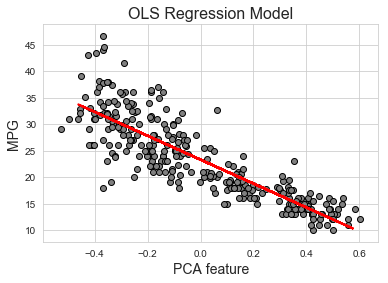

In [251]:
plt.plot(X_test, Y_, c='r', linewidth=2)
plt.scatter(X_train, Y_train, c='gray', marker='o', edgecolors='k')
plt.title('OLS Regression Model', size=16)
plt.xlabel('PCA feature', size=14)
plt.ylabel('MPG', size=14)
plt.show()

The OLS model does a decent job predicting `mpg`, however, because there is quite a bit of scatter present at low values of the `PCA_feature`, the model tends to underpredict high `mpg`'s.  Perhaps adding in the `model_yr` data will help.

In [252]:
X_2 = np.array(mpg[['pca_feature', 'model_yr']]).reshape(-1, 2)
Y_2 = np.array(mpg['mpg']).reshape(-1, 1)

X_2_train, X_2_test, Y_2_train, Y_2_test = train_test_split(X_2, Y_2, random_state=99)

In [253]:
regr_2 = LinearRegression().fit(X_2_train, Y_2_train)
Y_2_ = regr_2.predict(X_2_test)

print('R^2: ', r2_score(Y_2_test, Y_2_))

R^2:  0.783460356713086


While we can't visualize this model in 2D-space, the R^2 is much better than with just the PCA feature.  We can plot the errors for each model to see how they compare.

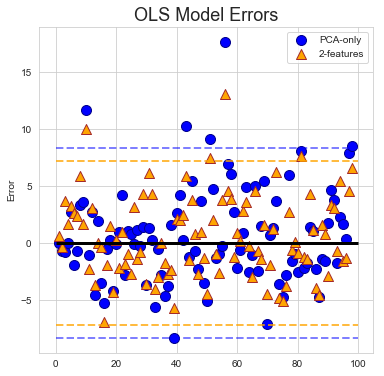

In [254]:
n_sample = np.arange(1,99)
regr_error = np.array(Y_test - Y_)
regr_2_error = np.array(Y_2_test - Y_2_)

regr_error_2std = np.std(regr_error) * 2
regr_2_error_2std = np.std(regr_2_error) * 2

plt.figure(figsize=(6,6))
plt.scatter(n_sample, regr_error, c='blue', marker='o', s=100, edgecolors='darkblue')
plt.scatter(n_sample, regr_2_error, c='orange', marker='^', s=100, edgecolor='brown')
plt.hlines(regr_error_2std, 0, 100, color='blue', linewidth=2, linestyles='--', alpha=0.5)
plt.hlines(regr_2_error_2std, 0, 100, color='orange', linewidth=2, linestyles='--', alpha=0.75)
plt.hlines(0, 0, 100, color='k', linewidth=3)
plt.hlines((regr_2_error_2std * -1), 0, 100, color='orange', linewidth=2, linestyles='--', alpha=0.75)
plt.hlines((regr_error_2std * -1), 0, 100, color='blue', linewidth=2, linestyles='--', alpha=0.5)
plt.title('OLS Model Errors', size=18)
plt.ylabel('Error')
plt.legend(['PCA-only', '2-features'], loc='best')
plt.show()


The absolute errors and the standard deviation for the 2-feature model are indeed smaller than the PCA-only model. Now let's instantiate a KNN model for both sets of data.

## KNN Regression

In [258]:
# Normalizing the data

X_knn = stats.zscore(mpg['pca_feature']).reshape(-1, 1)
Y_knn = stats.zscore(mpg['mpg']).reshape(-1, 1)

X_knn_train, X_knn_test, Y_knn_train, Y_knn_test = train_test_split(X_knn, Y_knn, random_state=99)

In [259]:
knn = KNeighborsRegressor(n_neighbors=23).fit(X_knn_train, Y_knn_train)
Y_knn_ = knn.predict(X_knn_test)

print('R^2: ', r2_score(Y_knn_test, Y_knn_))

R^2:  0.7328624928220804


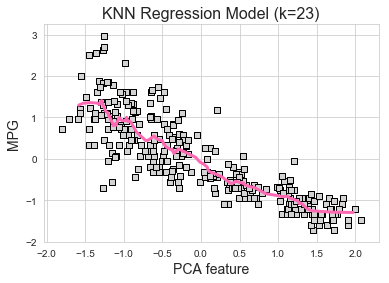

In [260]:
# Creating a sorted fitline from the KNN model
knn_fitline = np.hstack((X_knn_test, Y_knn_))
knn_fitline = knn_fitline[knn_fitline[:,0].argsort()]

plt.plot(knn_fitline[:, 0], knn_fitline[:, 1], c='hotpink', linewidth=3)
plt.scatter(X_knn_train, Y_knn_train, c='lightgray', marker='s', edgecolors='k')
plt.title('KNN Regression Model (k=23)', size=16)
plt.xlabel('PCA feature', size=14)
plt.ylabel('MPG', size=14)
plt.show()

After running through a variety of k's and distance weighting, the KNN model (using just the PCA feature) with the highest R^2 score is k=23 and unweighted.  This model performs just barely better than the OLS model in terms of R^2, but tracks the non-linearity, which OLS obviously does not do.

I'll add in the `model_yr` data to this model and see if we get a more accurate model.

In [261]:
# Normalizing the second set of data
X_knn2 = pd.DataFrame({
    'pca_feature': stats.zscore(mpg['pca_feature']),
    'model_yr': stats.zscore(mpg['model_yr'])
})
Y_knn2 = stats.zscore(mpg['mpg'])

X_knn2_train, X_knn2_test, Y_knn2_train, Y_knn2_test = train_test_split(X_knn2, Y_knn2, random_state=99)


In [309]:
knn2 = KNeighborsRegressor(n_neighbors=10).fit(X_knn2_train, Y_knn2_train)
Y_knn2_ = knn2.predict(X_knn2_test)

print('R^2: ', r2_score(Y_knn2_test, Y_knn2_))

R^2:  0.8347345029048912


Adding the `model_yr` data increased our R^2 score by 0.1 from the one-feature model and is 0.05 better than the equivalent OLS model.  Let's plot up the KNN errors like we did previously to confirm these scores.

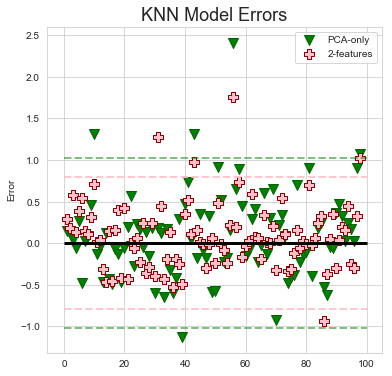

In [312]:
n_sample = np.arange(1,99)
knn_error = np.array(Y_knn_test - Y_knn_)
knn_2_error = np.array(Y_knn2_test - Y_knn2_)

knn_error_2std = np.std(knn_error) * 2
knn_2_error_2std = np.std(knn_2_error) * 2

plt.figure(figsize=(6,6))
plt.scatter(n_sample, knn_error, c='green', marker='v', s=100, edgecolors='darkgreen')
plt.scatter(n_sample, knn_2_error, c='pink', marker='P', s=100, edgecolor='darkred')
plt.hlines(knn_error_2std, 0, 100, color='green', linewidth=2, linestyles='--', alpha=0.5)
plt.hlines(knn_2_error_2std, 0, 100, color='pink', linewidth=2, linestyles='--', alpha=0.9)
plt.hlines(0, 0, 100, color='k', linewidth=3)
plt.hlines((knn_2_error_2std * -1), 0, 100, color='pink', linewidth=2, linestyles='--', alpha=0.9)
plt.hlines((knn_error_2std * -1), 0, 100, color='green', linewidth=2, linestyles='--', alpha=0.5)
plt.title('KNN Model Errors', size=18)
plt.ylabel('Error')
plt.legend(['PCA-only', '2-features'], loc='best')
plt.show()


## Model Comparison

These models perform very similarly.  Both sets of models show increased predictive capability when using the two-feature model.  The KNN models are modestly more performant than the OLS models, largely due to the slight lack of linearity in the PCA-feature correlation with `mpg`.  Because the OLS model is constrained by linear relations, it will always do less good than a non-linear model where the correlations with the target are not linear in nature.

If the correlations were, indeed, more linear, perhaps the KNN models would then tend to overfit the data and the OLS implementations would be preferred.